## Optimal Stopping Point

In this notebook, we will explore 2 different approaches to predict the optimal stopping point.

1. **Test Distributions** - In this approach, we try to identify the best statistical distribution for the tests based on their runtime durations and find the point in time beyond which a test has a higher chance of failing

2. **Pass Fail Likelihood** - In this approach, we find the time duration ranges for a given test based on which we find the likelihood of the test failing

In [1]:
## Import libraries
import os
import gzip
import json
import datetime
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

import warnings

warnings.filterwarnings("ignore")
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions

## Helper Functions

In [2]:
def find_turning_point(s, lower, upper):

    # Find the point after which the test is 75% likely to fail 
    # and at all points after then it is never less than 60% likely to fail.
    # Can also parameterize these percentages
    
    sub = pd.Series()
    turning_point = 0
    for index, value in s[::-1].iteritems():
        if value > lower:
            sub.loc[index] = value
        else:
            if sub.empty:
                return 0
            elif not sub.empty:
                turning_point = (sub[::-1] >= upper).idxmax()
                return turning_point

## Import Data

We will be fetching the test runs under the workflow "Post PR Comment" from the CodeQL repository: https://github.com/github/codeql/actions/workflows/post-pr-comment.yml

In [37]:
test_id = "14909022" # "CodeQL tests"

In [38]:
passing_train = pd.read_csv("../data/processed/{}passing_train.csv".format(test_id))
failing_train = pd.read_csv("../data/processed/{}failing_train.csv".format(test_id))

## Approach 1: Find Distributions

In this approach, we will we approximate the distributions of the test duration value and also check its goodness of fit for different tests. Based on the type of distribution identified, we calculate the probability of the test failing.

### Failing Test Distribution

In [5]:
# Since the data here is heavily skewed, hence implementing 
# log transformation here.
failing_train.run_duration = np.log(failing_train.run_duration)

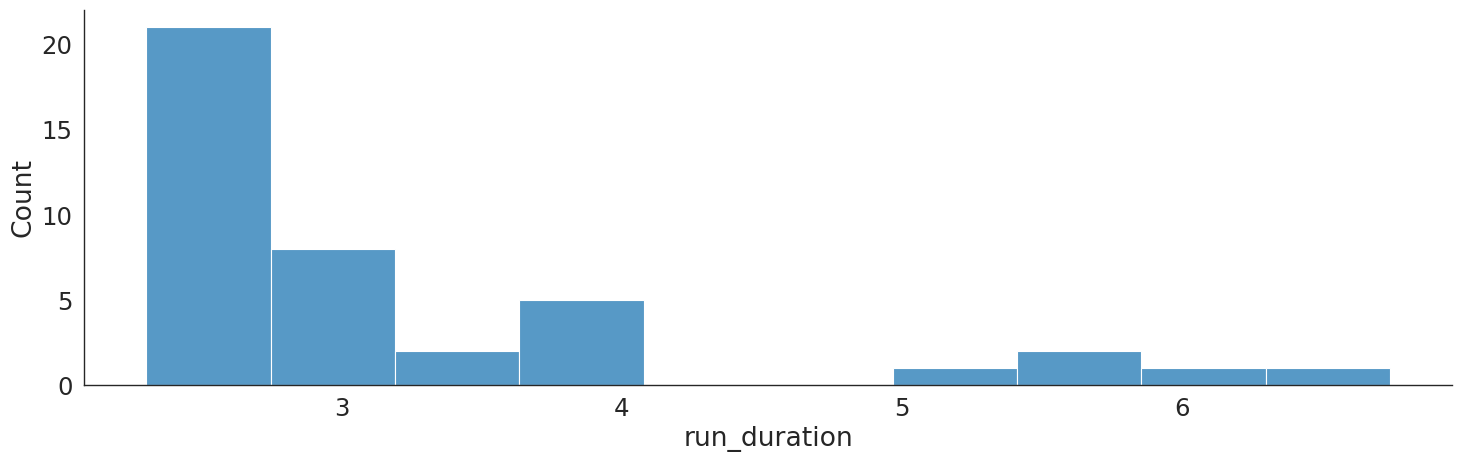

In [6]:
# Distribution of values of failing run duration
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=failing_train, x="run_duration", kind="hist", bins = 10, aspect = 3)

In [7]:
# create a separate set of values for failing durations
fail_run_duration = failing_train.run_duration.values

In [8]:
# Filter for all finite values
x = fail_run_duration[np.isfinite(fail_run_duration)]

Fitting 110 distributions:  93%|█████████▎| 102/110 [01:34<00:13,  1.74s/it]SKIPPED vonmises distribution (taking more than 30 seconds)
SKIPPED vonmises_line distribution (taking more than 30 seconds)
Fitting 110 distributions: 100%|██████████| 110/110 [02:07<00:00,  1.16s/it]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
halfcauchy,0.059518,53.513484,-260.510156,inf,0.189248,0.092684
invgauss,0.069992,53.323521,-250.149986,inf,0.141081,0.354547
geninvgauss,0.072235,56.650638,-245.143320,inf,0.139480,0.368056
powerlognorm,0.073826,56.838241,-244.249861,inf,0.137916,0.381557
cauchy,0.075579,71.622435,-250.714965,inf,0.253022,0.008430


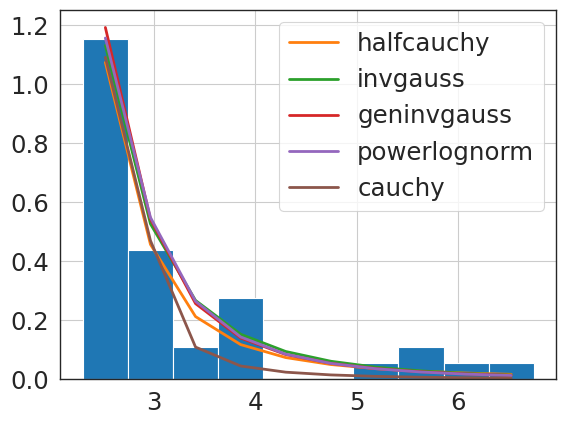

In [9]:
f = Fitter(x,
           distributions=get_distributions(), bins=10)
f.fit()
f.summary()

In [10]:
# Find best failing distribution
best_failing_dist = f.get_best(method="sumsquare_error")
best_failing_dist

{'halfcauchy': {'loc': 2.302585091291472, 'scale': 0.49327104546535516}}

Fitting 1 distributions: 100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
halfcauchy,0.059518,53.513484,-260.510156,inf,0.189248,0.092684


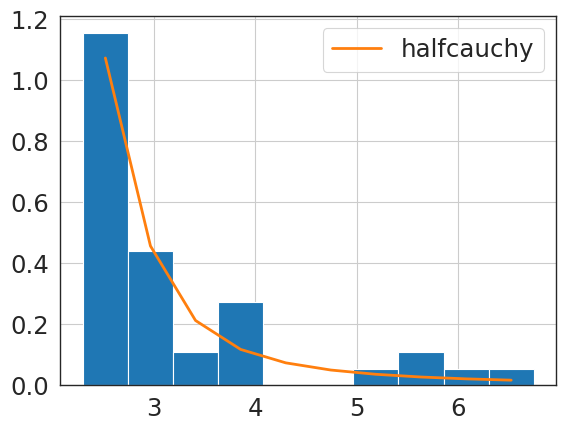

In [11]:
f = Fitter(x,
           distributions=best_failing_dist, bins =10)
f.fit()
f.summary()

In [12]:
f_dist = list(best_failing_dist.keys())[0]
# Calculate the parameters for the failing distribution curve
f_params = f.fitted_param[f_dist]
f_params

(2.302585091291472, 0.49327104546535516)

### Passing Test Distribution

In [13]:
# Since the failing data here is heavily skewed, hence implementing 
# log transformation here as well so we can get an OSP after reversing the log.
passing_train.run_duration = np.log(passing_train.run_duration)

In [14]:
# create a separate set of values for the passing run times.
pass_run_duration = passing_train.run_duration.values

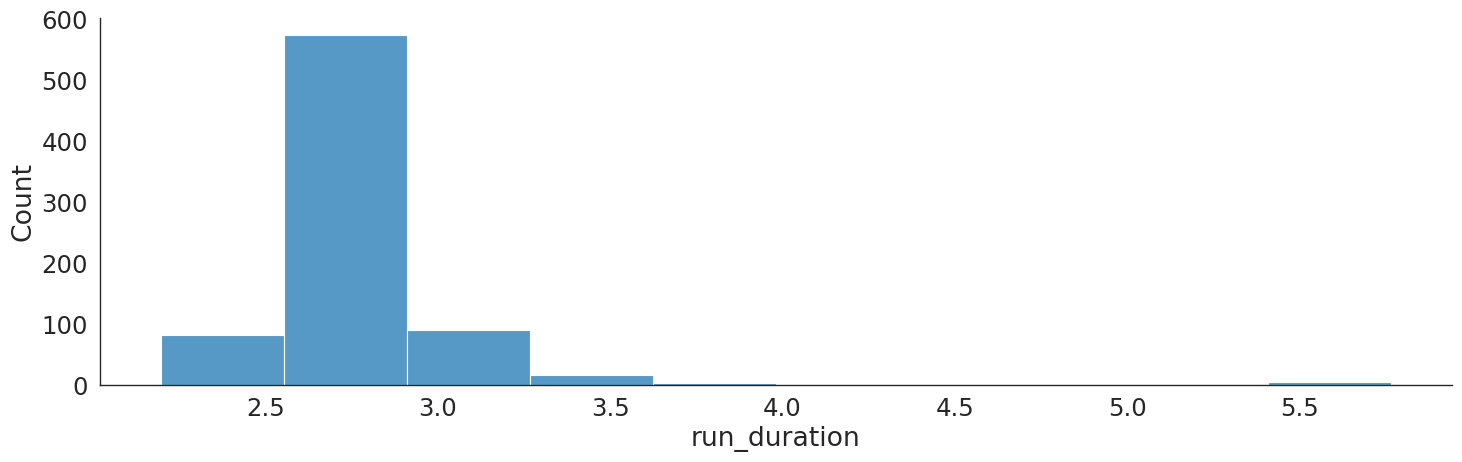

In [15]:
# Distribution of values of passing run duration
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=passing_train, x="run_duration", kind="hist", bins = 10, aspect = 3)

Fitting 110 distributions:  79%|███████▉  | 87/110 [07:00<01:23,  3.62s/it]SKIPPED rv_continuous distribution (taking more than 30 seconds)
SKIPPED rv_histogram distribution (taking more than 30 seconds)
Fitting 110 distributions: 100%|██████████| 110/110 [10:01<00:00,  5.47s/it]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
mielke,0.015793,101.511395,-8297.034932,inf,0.108762,2.133011e-08
logistic,0.019975,180.670869,-8129.214483,inf,0.113152,4.697502e-09
genhyperbolic,0.021164,94.486517,-8064.686401,inf,0.110071,1.367278e-08
exponnorm,0.021931,117.524532,-8050.547227,inf,0.109681,1.561457e-08
hypsecant,0.027197,160.483454,-7891.243895,inf,0.109146,1.872930e-08


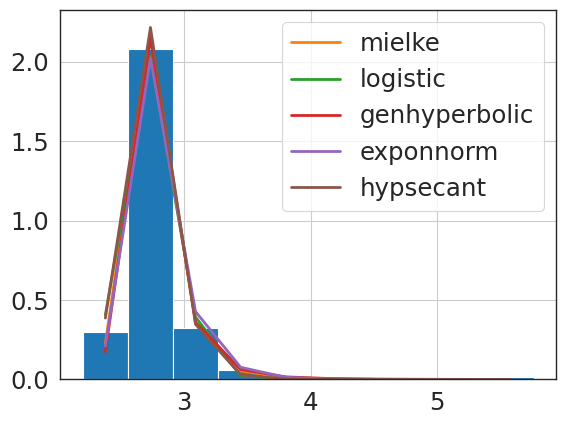

In [16]:
p = Fitter(pass_run_duration,
           distributions=get_distributions(), bins =10)
p.fit()
p.summary()

In [17]:
# find the best passing distribution
best_passing_dist = p.get_best(method="sumsquare_error")
best_passing_dist

{'mielke': {'k': 5.389048456829901,
  's': 5.520106125784183,
  'loc': 2.1068370919655406,
  'scale': 0.6144911956379884}}

Fitting 1 distributions: 100%|██████████| 1/1 [00:30<00:00, 30.40s/it]
mielke was not fitted. no parameters available
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
mielke,inf,inf,inf,inf,NaN,NaN


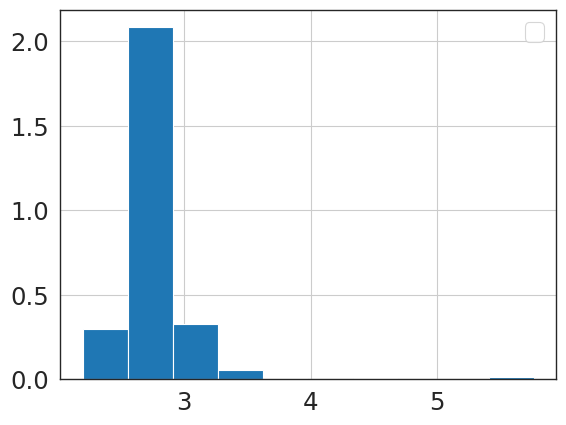

In [18]:
p = Fitter(pass_run_duration,
           distributions=best_passing_dist, bins =10)
p.fit()
p.summary()

## Approach 2: Find the likelihood of test failing

In this approach, we will be bucketing the test runtime durations into 30 second intervals and find the likelihood of the test failing. By default, we define the **threshold as 75%** after which the test is likely to fail. This threshold can be customized as per your liking.

In [46]:
passing_train = pd.read_csv("../data/processed/{}passing_train.csv".format(test_id))
failing_train = pd.read_csv("../data/processed/{}failing_train.csv".format(test_id))

In [39]:
# bucketing into 30 second intervals

ranges = np.arange(0, max(passing_train['run_duration'])+1, 10).tolist()
ranges.append(np.inf)
passing_train['run_duration_ranges'] = pd.cut(passing_train['run_duration'], bins=ranges)
failing_train['run_duration_ranges'] = pd.cut(failing_train['run_duration'], bins=ranges)
p_vc = pd.DataFrame(passing_train['run_duration_ranges'].value_counts().sort_index())
f_vc = pd.DataFrame(failing_train['run_duration_ranges'].value_counts().sort_index())

In [40]:
p_vc['prefix_sum'] = p_vc['run_duration_ranges'][::-1].cumsum()[::-1]
f_vc['prefix_sum'] = f_vc['run_duration_ranges'][::-1].cumsum()[::-1]

In [41]:
max_duration = max(p_vc['prefix_sum'])
p_vc['prefix_sum_percentage'] = p_vc['prefix_sum'] / max_duration * 100
p_vc

,run_duration_ranges,prefix_sum,prefix_sum_percentage
"(0.0, 10.0]",6,771,100.000000
"(10.0, 20.0]",694,765,99.221790
"(20.0, 30.0]",58,71,9.208820
"(30.0, 40.0]",4,13,1.686122
"(40.0, 50.0]",2,9,1.167315
"(50.0, 60.0]",0,7,0.907912
"(60.0, 70.0]",0,7,0.907912
"(70.0, 80.0]",1,7,0.907912
"(80.0, 90.0]",1,6,0.778210
"(90.0, 100.0]",0,5,0.648508


In [42]:
max_duration = max(f_vc['prefix_sum'])
f_vc['prefix_sum_percentage'] = f_vc['prefix_sum'] / max_duration * 100
f_vc

,run_duration_ranges,prefix_sum,prefix_sum_percentage
"(0.0, 10.0]",1,41,100.000000
"(10.0, 20.0]",27,40,97.560976
"(20.0, 30.0]",2,13,31.707317
"(30.0, 40.0]",1,11,26.829268
"(40.0, 50.0]",4,10,24.390244
"(50.0, 60.0]",1,6,14.634146
"(60.0, 70.0]",0,5,12.195122
"(70.0, 80.0]",0,5,12.195122
"(80.0, 90.0]",0,5,12.195122
"(90.0, 100.0]",0,5,12.195122


In [43]:
# join dataframes a and b on their index
joined = f_vc.join(p_vc, how='outer', lsuffix='_f', rsuffix='_p')

total = joined[['prefix_sum_f', 'prefix_sum_p']].sum(axis=1)
joined['f_pct'] = joined['prefix_sum_f'] / total * 100
joined['p_pct'] = joined['prefix_sum_p'] / total * 100

In [44]:
joined.head()

,run_duration_ranges_f,prefix_sum_f,prefix_sum_percentage_f,run_duration_ranges_p,prefix_sum_p,prefix_sum_percentage_p,f_pct,p_pct
"(0.0, 10.0]",1,41,100.000000,6,771,100.000000,5.049261,94.950739
"(10.0, 20.0]",27,40,97.560976,694,765,99.221790,4.968944,95.031056
"(20.0, 30.0]",2,13,31.707317,58,71,9.208820,15.476190,84.523810
"(30.0, 40.0]",1,11,26.829268,4,13,1.686122,45.833333,54.166667
"(40.0, 50.0]",4,10,24.390244,2,9,1.167315,52.631579,47.368421


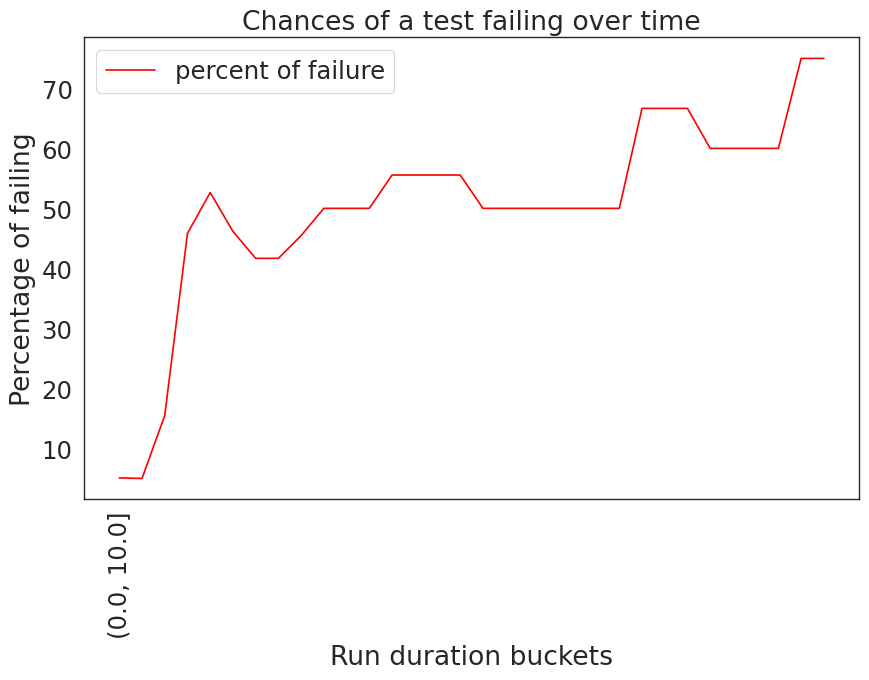

In [45]:
# plot the two series on the same graph

tick_spacing = 200

plt.figure(figsize=(10, 6))
plt.plot(joined.index.astype(str), joined['f_pct'], color='red', label='percent of failure')

# set x and y axis labels
plt.xlabel('Run duration buckets')
plt.ylabel('Percentage of failing')
plt.xticks(rotation=90)
plt.xticks(np.arange(0, len(joined.index.astype(str)), tick_spacing), joined.index.astype(str)[::tick_spacing])

# set title and legend
plt.title('Chances of a test failing over time')
plt.legend()

# show the plot
plt.show()

In [47]:
tp = find_turning_point(joined['f_pct'], 60, 75)

In [48]:
tp

Interval(300.0, 310.0, closed='right')

In [49]:
passing_test = pd.read_csv("../data/processed/{}passing_test.csv".format(test_id))
failing_test = pd.read_csv("../data/processed/{}failing_test.csv".format(test_id))

In [50]:
test_data = pd.concat([passing_test, failing_test], axis=0)

In [51]:
# Add new column with "success" or "failure" based on run_duration
test_data['predicted_status'] = np.where(test_data['run_duration'] > tp.left, 'failure', 'success')

In [52]:
precision, recall, f1_score, support = precision_recall_fscore_support(test_data['predicted_status'], test_data['conclusion'], average='binary', pos_label='success')

In [53]:
precision

1.0

In [54]:
recall

0.9414634146341463

In [55]:
f1_score

0.9698492462311558

### Normalize

We will now repeat the same method as above, but with the normalized test duration/runtime values and compare the results.

In [56]:
passing_train = pd.read_csv("../data/processed/{}passing_train.csv".format(test_id))
failing_train = pd.read_csv("../data/processed/{}failing_train.csv".format(test_id))

In [57]:
# bucketing into 30 second intervals

ranges = np.arange(0, max(passing_train['run_duration'])+1, 10).tolist()
ranges.append(np.inf)
passing_train['run_duration_ranges'] = pd.cut(passing_train['run_duration'], bins=ranges)
failing_train['run_duration_ranges'] = pd.cut(failing_train['run_duration'], bins=ranges)
p_vc = pd.DataFrame(passing_train['run_duration_ranges'].value_counts().sort_index())
f_vc = pd.DataFrame(failing_train['run_duration_ranges'].value_counts().sort_index())

In [58]:
combined_vc = pd.concat([p_vc, f_vc], axis=1, keys=['p_', 'f_'])
combined_vc['total'] = combined_vc[('p_', 'run_duration_ranges')] + combined_vc[('f_', 'run_duration_ranges')]
combined_vc[('p_', 'run_duration_ranges')] = combined_vc[('p_', 'run_duration_ranges')]/combined_vc['total']
combined_vc[('f_', 'run_duration_ranges')] = combined_vc[('f_', 'run_duration_ranges')]/combined_vc['total']
combined_vc = combined_vc.fillna(0)
combined_vc

,p_,f_,total
,run_duration_ranges,run_duration_ranges,
"(0.0, 10.0]",0.857143,0.142857,7
"(10.0, 20.0]",0.962552,0.037448,721
"(20.0, 30.0]",0.966667,0.033333,60
"(30.0, 40.0]",0.800000,0.200000,5
"(40.0, 50.0]",0.333333,0.666667,6
"(50.0, 60.0]",0.000000,1.000000,1
"(60.0, 70.0]",0.000000,0.000000,0
"(70.0, 80.0]",1.000000,0.000000,1
"(80.0, 90.0]",1.000000,0.000000,1


In [59]:
p_vc = combined_vc['p_']
f_vc = combined_vc['f_']

In [60]:
p_vc['prefix_sum'] = p_vc['run_duration_ranges'][::-1].cumsum()[::-1]
f_vc['prefix_sum'] = f_vc['run_duration_ranges'][::-1].cumsum()[::-1]

In [61]:
p_vc

,run_duration_ranges,prefix_sum
"(0.0, 10.0]",0.857143,9.169695
"(10.0, 20.0]",0.962552,8.312552
"(20.0, 30.0]",0.966667,7.350000
"(30.0, 40.0]",0.800000,6.383333
"(40.0, 50.0]",0.333333,5.583333
"(50.0, 60.0]",0.000000,5.250000
"(60.0, 70.0]",0.000000,5.250000
"(70.0, 80.0]",1.000000,5.250000
"(80.0, 90.0]",1.000000,4.250000
"(90.0, 100.0]",0.000000,3.250000


In [62]:
f_vc

,run_duration_ranges,prefix_sum
"(0.0, 10.0]",0.142857,4.830305
"(10.0, 20.0]",0.037448,4.687448
"(20.0, 30.0]",0.033333,4.650000
"(30.0, 40.0]",0.200000,4.616667
"(40.0, 50.0]",0.666667,4.416667
"(50.0, 60.0]",1.000000,3.750000
"(60.0, 70.0]",0.000000,2.750000
"(70.0, 80.0]",0.000000,2.750000
"(80.0, 90.0]",0.000000,2.750000
"(90.0, 100.0]",0.000000,2.750000


In [63]:
# join dataframes a and b on their index
joined = f_vc.join(p_vc, how='outer', lsuffix='_f', rsuffix='_p')

total = joined[['prefix_sum_f', 'prefix_sum_p']].sum(axis=1)
joined['f_pct'] = joined['prefix_sum_f'] / total * 100
joined['p_pct'] = joined['prefix_sum_p'] / total * 100

In [64]:
joined.head()

,run_duration_ranges_f,prefix_sum_f,run_duration_ranges_p,prefix_sum_p,f_pct,p_pct
"(0.0, 10.0]",0.142857,4.830305,0.857143,9.169695,34.502180,65.497820
"(10.0, 20.0]",0.037448,4.687448,0.962552,8.312552,36.057292,63.942708
"(20.0, 30.0]",0.033333,4.650000,0.966667,7.350000,38.750000,61.250000
"(30.0, 40.0]",0.200000,4.616667,0.800000,6.383333,41.969697,58.030303
"(40.0, 50.0]",0.666667,4.416667,0.333333,5.583333,44.166667,55.833333


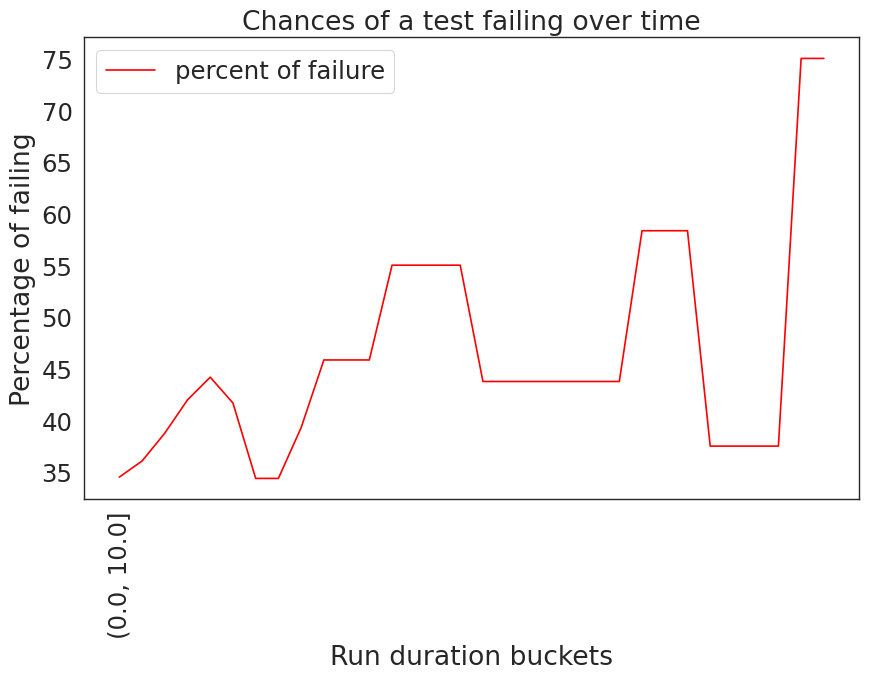

In [65]:
# plot the two series on the same graph

tick_spacing = 200

plt.figure(figsize=(10, 6))
plt.plot(joined.index.astype(str), joined['f_pct'], color='red', label='percent of failure')

# set x and y axis labels
plt.xlabel('Run duration buckets')
plt.ylabel('Percentage of failing')
plt.xticks(rotation=90)
plt.xticks(np.arange(0, len(joined.index.astype(str)), tick_spacing), joined.index.astype(str)[::tick_spacing])

# set title and legend
plt.title('Chances of a test failing over time')
plt.legend()

# show the plot
plt.show()

In [66]:
tp = find_turning_point(joined['f_pct'], 60, 75)

In [67]:
tp

Interval(300.0, 310.0, closed='right')

In [68]:
test_data = pd.concat([passing_test, failing_test], axis=0)

In [69]:
# Add new column with "success" or "failure" based on run_duration
test_data['predicted_status'] = np.where(test_data['run_duration'] > tp.left, 'failure', 'success')

In [70]:
precision, recall, f1_score, support = precision_recall_fscore_support(test_data['predicted_status'], test_data['conclusion'], average='binary', pos_label='success')

In [71]:
precision

1.0

In [72]:
recall

0.9414634146341463

In [73]:
f1_score

0.9698492462311558

We see that there is no benefit of normalizing the data as the result is either the same or the failure percentage is scaled too low. Hence, for now we will proceed without normalizing the data.

### Scaling

We will now repeat the same method as above, but with the scaled test duration/runtime values and compare the results.

In [74]:
# As we saw earlier, scaling does not impact the stopping point hence commenting it out
t_vc = pd.concat([p_vc, f_vc], axis=0)
scaler = MinMaxScaler()
t_vc['run_duration_ranges'] =  scaler.fit_transform(t_vc[['run_duration_ranges']])
rows_split = len(p_vc)  # Number of rows to split on
p_vc = t_vc.head(rows_split)  # First dataframe
f_vc = t_vc.tail(len(t_vc) - rows_split) 

In [75]:
# join dataframes a and b on their index
joined = f_vc.join(p_vc, how='outer', lsuffix='_f', rsuffix='_p')

total = joined[['prefix_sum_f', 'prefix_sum_p']].sum(axis=1)
joined['f_pct'] = joined['prefix_sum_f'] / total * 100
joined['p_pct'] = joined['prefix_sum_p'] / total * 100

In [76]:
joined.head()

,run_duration_ranges_f,prefix_sum_f,run_duration_ranges_p,prefix_sum_p,f_pct,p_pct
"(0.0, 10.0]",0.142857,4.830305,0.857143,9.169695,34.502180,65.497820
"(10.0, 20.0]",0.037448,4.687448,0.962552,8.312552,36.057292,63.942708
"(20.0, 30.0]",0.033333,4.650000,0.966667,7.350000,38.750000,61.250000
"(30.0, 40.0]",0.200000,4.616667,0.800000,6.383333,41.969697,58.030303
"(40.0, 50.0]",0.666667,4.416667,0.333333,5.583333,44.166667,55.833333


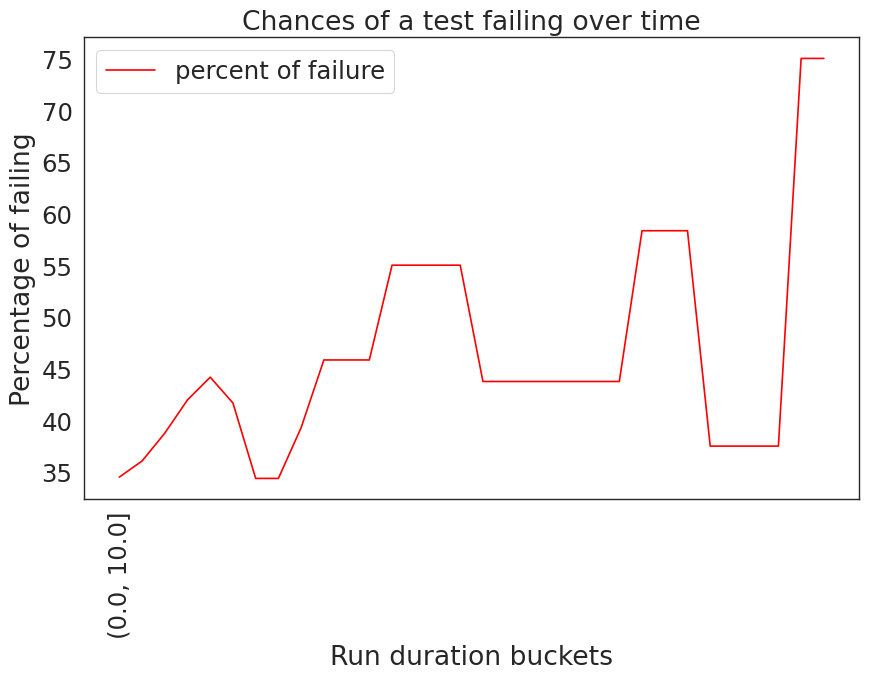

In [77]:
# plot the two series on the same graph

tick_spacing = 200

plt.figure(figsize=(10, 6))
plt.plot(joined.index.astype(str), joined['f_pct'], color='red', label='percent of failure')

# set x and y axis labels
plt.xlabel('Run duration buckets')
plt.ylabel('Percentage of failing')
plt.xticks(rotation=90)
plt.xticks(np.arange(0, len(joined.index.astype(str)), tick_spacing), joined.index.astype(str)[::tick_spacing])

# set title and legend
plt.title('Chances of a test failing over time')
plt.legend()

# show the plot
plt.show()

In [78]:
tp = find_turning_point(joined['f_pct'], 60, 75)
tp

Interval(300.0, 310.0, closed='right')

From the above, we see that there no impact of scaling the data on the final result. Hence, for now we will proceed without normalizing or scaling.

# Conclusion

In this notebook, we evaluated the trends of passing and failing tests and plotted the likelihood of a test to pass or fail throughout the run duration of tests.

For every time interval T, we sum all the successes from T to N (the end if the dataset) divided by the total number of tests in that set. This answers "Given it is now time T, what is the probability that my test will succeed should I allow it to continue" 

Upon normalizing the data, ie. scaling the number of tests within each 10 or 30 second time range to be between 0 & 1, we see that there no impact of normalizing the data on the final result. Hence, for now we will proceed without normalizing or scaling. 

We also saw that for some tests there is no optimal stopping point - meaning it never occurs that a test is more likely to fail than pass.